In [0]:
'''Mount Drive to Google Colab'''
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive/')

In [0]:
import os
import time
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
from scipy.io import loadmat
import seaborn as sns

##Download dataset
Note that download command can only run on Linux-based environment / Google Colab

In [0]:
'''Linux command'''
# Download dataset and annotations from https://ai.stanford.edu/~jkrause/cars/car_dataset.html
# Unzip folder

if not os.path.exists('dataset'):
  os.mkdir('dataset')
!wget http://imagenet.stanford.edu/internal/car196/cars_train.tgz -O dataset/cars_train.tgz
!tar xzf dataset/cars_train.tgz -C dataset/

!wget http://imagenet.stanford.edu/internal/car196/cars_test.tgz -O dataset/cars_test.tgz
!tar xzf dataset/cars_test.tgz -C dataset/

!wget https://ai.stanford.edu/~jkrause/cars/car_devkit.tgz -O dataset/car_devkit.tgz
!tar xzf dataset/car_devkit.tgz -C dataset/

!ls dataset

--2019-06-11 14:32:16--  http://imagenet.stanford.edu/internal/car196/cars_train.tgz
Resolving imagenet.stanford.edu (imagenet.stanford.edu)... 171.64.68.16
Connecting to imagenet.stanford.edu (imagenet.stanford.edu)|171.64.68.16|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 979269282 (934M) [application/x-gzip]
Saving to: ‘dataset/cars_train.tgz’

dataset/cars_train. 100%[===================>] 933.90M   908KB/s    in 9m 10s  

2019-06-11 14:41:26 (1.70 MB/s) - ‘dataset/cars_train.tgz’ saved [979269282/979269282]

--2019-06-11 14:41:37--  http://imagenet.stanford.edu/internal/car196/cars_test.tgz
Resolving imagenet.stanford.edu (imagenet.stanford.edu)... 171.64.68.16
Connecting to imagenet.stanford.edu (imagenet.stanford.edu)|171.64.68.16|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 977350468 (932M) [application/x-gzip]
Saving to: ‘dataset/cars_test.tgz’

dataset/cars_test.t 100%[===================>] 932.07M  3.07MB/s    in 11m 12

##Essential functions

In [0]:
from tensorflow.keras import models, layers, Model, optimizers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input

def load_annotation_from_mat(path_to_annos_mat):
    '''
    DESRIPTION:
    path_to_annos_mat: path to the train/test mat file e.g. '/path/cars_test_anno.mat'
    Return: Annotation details (DataFrame)
    '''
    loaded_anno_file = loadmat(path_to_annos_mat)
    # get total column in annotation file
    total_column = len(loaded_anno_file['annotations'][0][0])
    if (total_column == 6): #train annotation loaded
        frame = [[i.flat[0] for i in line] for line in loaded_anno_file['annotations'][0]]
        columns = ['bbox_x1', 'bbox_y1', 'bbox_x2', 'bbox_y2', 'class', 'fname']
        df = pd.DataFrame(frame, columns=columns)
    else: #test annotation loaded
        frame = [[i.flat[0] for i in line] for line in loaded_anno_file['annotations'][0]]
        columns = ['bbox_x1', 'bbox_y1', 'bbox_x2', 'bbox_y2', 'fname']
        df = pd.DataFrame(frame, columns=columns)
    return df

def load_label_from_mat(path_to_meta_mat):
    '''
    DESRIPTION:
    path_to_meta_mat: path to meta mat file e.g. '/path/cars_meta.mat'
    '''
    # read cars labels from cars_meta.mat
    cars_meta = loadmat(path_to_meta_mat)
    labels = [c for c in cars_meta['class_names'][0]]
    labels = pd.DataFrame(labels, columns=['label_name'], index=np.arange(1,197))
    labels = labels.sort_values(by=['label_name'])
    return [{k:v} for k,v in labels['label_name'].items()]

def build_model():
    '''
    Return: Keras model
    '''
    class_no = 196
    # load pretrained model weights
    base_model = InceptionResNetV2(weights='imagenet', input_shape=(299, 299, 3), include_top=False)
    x = base_model.output # extract bottlenecks from pretrained convolutional network
    x = layers.GlobalAveragePooling2D()(x) # add pooling layer
    x = layers.Dropout(rate=0.0)(x) # regularizer is set to 0.0 in evaluation
    x = layers.Dense(512, activation='relu')(x) # add fully connected layer with 512 nodes & Relu activation
    x = layers.Dropout(rate=0.0)(x)
    predictions = layers.Dense(class_no, activation='softmax')(x) # prediction outputs in last layer with softmax activation
    model = Model(inputs=base_model.input, outputs=predictions) # connect all the layers above and return as a model
    return model 

def load_model(saved_weights):
    '''
    DESCRIPTION:
    saved_model, saved_weights: saved Keras model in .h5 format
    Return: Keras model
    '''
    model = build_model()
    model.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(0.0), metrics=['accuracy'])
    model.load_weights(saved_weights)
    print('Model loaded successfully')
    return model

def map_prediction_order(y_predict, meta_labels):
    '''
    DESRIPTION:
    y_predict: predicted label index for single image (note that y_predict is in range 0-195)
    meta_labels: A list that store meta labels and its corresponding index based on
    ascending alphabet order
    Return: label index(int) e.g. 196
    
    Since Keras generator organize label indices based on first alphabet of label name,
    hence we need to map the predicted label indices based on the order in car meta file
    '''
    return [key for key in meta_labels[(y_predict)].keys()][0]

def predict(path_to_annos_mat, path_to_meta_mat, path_to_images, saved_model):
    '''
    DESRIPTION:
    path_to_annos_mat: path to the train/test mat file e.g. '/path/cars_test_anno.mat'
    path_to_meta_mat: path to meta mat file e.g. '/path/cars_meta.mat'
    path_to_images: path to images that going to be evaluated e.g. '/path/image_dir'
    saved_model: saved Keras model
    Return: Predicted label indices (list)
    '''
    start_time = time.time()
    predictions = []
    df = load_annotation_from_mat(path_to_annos_mat)
    #read images from filename
    image_dimensions = 299
    image_depth = 3
    filenames = path_to_images +'/'+ df['fname']
    meta_labels = load_label_from_mat(path_to_meta_mat)
    # loop thru each image and predict
    for index, f in enumerate(filenames):
        x = image.load_img(f, target_size=(image_dimensions, image_dimensions, image_depth))
        x = image.img_to_array(x)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        y_predict = np.argmax(saved_model.predict(x), 1)
        y_predict = map_prediction_order(y_predict[0], meta_labels)
        predictions.append(y_predict)
        print('\rprogress:', index+1, "       ", end='')
    #save predictions to txt file
    np.savetxt('predictions.txt', predictions, fmt='%d')
    print('Result saved to predictions.txt')
    print("--- %s seconds ---" % (time.time() - start_time))
    return predictions

def sort_pred(truth_labels, preds):
  '''
  DESCRIPTION:
  truth_labels: A list that store label index (as annotated in car meta) and label name
  preds: A list of predicted accuracy
  Return: Sorted results based on descending accuracy
  '''
  result = []
  sort_result = {}
  for index, label in enumerate(truth_labels):
    label_index = [k for k in label.keys()][0]
    label_name = [v for v in label.values()][0]
    result.append((label_index, label_name, '%.2f' % (preds[0][index] * 100)))
    result.sort(key=lambda ele: -np.float32(ele[2]))
  return result
  
def predict_top_k(path_to_images, path_to_meta_mat, saved_weights, top_k, model):
  '''
  DESCRIPTION:
  top_k: Specify how many top results to output
  Return: Sorted top result list
  '''
  x = image.load_img(path_to_images, target_size=(299, 299, 3))
  x = image.img_to_array(x)
  x = np.expand_dims(x, axis=0)
  x = preprocess_input(x)
  pred = model.predict(x)
  meta_labels = load_label_from_mat(path_to_meta_mat)
  return sort_pred(meta_labels, pred)[:top_k]

##Define required file path

In [0]:
cars_meta = 'dataset/devkit/cars_meta.mat'
cars_train_annos = 'dataset/devkit/cars_train_annos.mat'
cars_test_annos = 'dataset/devkit/cars_test_annos.mat'
path_to_test_images = 'dataset/cars_test'
saved_model_weights = 'drive/My Drive/stage2_model_weights.h5'

##Load saved model

In [0]:
model = load_model(saved_model_weights)

Instructions for updating:
Colocations handled automatically by placer.
219062272/219055592 [==============================] - 8s 0us/step
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model loaded successfully


##Run prediction
Predictions for testing images will be saved as predictions.txt for evaluation.

In [0]:
predictions = predict(cars_test_annos, cars_meta, path_to_test_images, saved_model=model)

progress: 8041        Result saved to predictions.txt
--- 571.6171555519104 seconds ---


## Output top K predictions

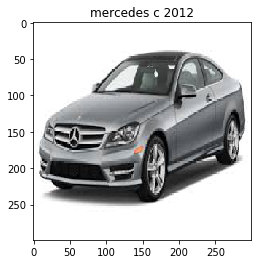

In [11]:
x = image.load_img('mercedes-c-2012.jpg', target_size=(299, 299, 3))
x = image.img_to_array(x).astype(int)
fig = plt.figure()
plt.title('mercedes c 2012')
plt.imshow(x)
plt.show()

In [0]:
predict_top_k('mercedes-c-2012.jpg', cars_meta, saved_model_weights, top_k=5, model=model)

[(162, 'Mercedes-Benz C-Class Sedan 2012', '100.00'),
 (1, 'AM General Hummer SUV 2000', '0.00'),
 (6, 'Acura Integra Type R 2001', '0.00'),
 (2, 'Acura RL Sedan 2012', '0.00'),
 (3, 'Acura TL Sedan 2012', '0.00')]